In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

service_fault_codes = pd.read_excel('../data/Service Fault Codes_1_0_0_167.xlsx')
faults = pd.read_csv('../data/J1939Faults.csv', low_memory=False)
diagnostics = pd.read_csv('../data/VehicleDiagnosticOnboardData.csv', low_memory=False)

# Define the service locations
service_locations = [(36.0666667, -86.4347222), (35.5883333, -86.4438888), (36.1950, -83.174722)]

# Filter out faults occurring within 2 miles of service locations
for loc in service_locations:
    lat_mile = 2/69 # Convert 2 miles to degrees of latitude
    lon_mile = 1/(69*np.cos(np.radians(loc[0]))) * 2 # Convert 2 miles to degrees of longitude at the given latitude
    faults = faults[(np.abs(faults['Latitude'] - loc[0]) > lat_mile) | (np.abs(faults['Longitude'] - loc[1]) > lon_mile)]
faults = faults[faults['EquipmentID'].str.len() <= 5]
faults

C:\Users\17202\anaconda3\envs\pycaret\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,False,127,NaN,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:26.000
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,True,127,NaN,1369,105336226,41.421018,-87.767361,2015-02-21 11:36:08.000
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,NaN,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:37.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187330,1248454,123904424,2020-03-06 14:00:26.000,Low (Severity Low) Catalyst Tank Level,NaN,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,1761,17,False,3,NaN,2282,105439740,37.094768,-85.897407,2020-03-06 14:00:21.000
1187331,1248455,123905139,2020-03-06 14:04:23.000,Condition Exists Engine Protection Torque Derate,NaN,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,1569,31,True,5,NaN,1994,105354084,34.390740,-79.461805,2020-03-06 14:04:59.000
1187332,1248456,123905996,2020-03-06 14:13:38.000,Abnormal Rate of Change Aftertreatment 1 Intak...,NaN,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,10,True,1,NaN,1850,105336308,34.430370,-84.920509,2020-03-06 14:14:14.000
1187333,1248457,123906113,2020-03-06 14:14:13.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,111,18,True,8,NaN,2377,108605700,35.030925,-85.321527,2020-03-06 14:14:49.000


In [2]:
wide_diag = diagnostics.pivot(index='FaultId', columns='Name', values='Value')

fault_diag = pd.merge(left = faults,
         right = wide_diag,
         left_on = 'RecordID',
         right_on = 'FaultId'
        )
fault_diag

derates=fault_diag.loc[fault_diag['spn'].isin([5246, 1569])]
full_derate = derates.loc[derates['spn'].isin([5246])]
full_derate

# Extract unique EquipmentID numbers from full_derate
unique_equip_ids = full_derate['EquipmentID'].unique()

# Filter rows in fault_diag based on unique_equip_ids
fault_diag_filtered = fault_diag[fault_diag['EquipmentID'].isin(unique_equip_ids)]
fault_diag_filtered
fault_diag_filtered = fault_diag_filtered[fault_diag_filtered['active'] == True]
fault_diag_filtered
fault_diag_filtered = fault_diag_filtered.sort_values(by=['EquipmentID','EventTimeStamp'], ascending=[True, True])
fault_diag_filtered = fault_diag_filtered.drop(columns=['ParkingBrake','LocationTimeStamp','active','CruiseControlActive', 'CruiseControlSetSpeed', 'MCTNumber', 'ecuSoftwareVersion', 'ecuSerialNumber','actionDescription', 'faultValue', 'ServiceDistance', 'SwitchedBatteryVoltage'])
fault_diag_filtered

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure
5114,5713,1070644,2015-02-25 13:53:08.000,NaN,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527,NaN,NaN,NaN
5115,5714,1070646,2015-02-25 13:53:08.000,NaN,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527,NaN,NaN,NaN
5116,5715,1070647,2015-02-25 13:53:08.000,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527,NaN,NaN,NaN
5117,5716,1070648,2015-02-25 13:53:08.000,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527,NaN,NaN,NaN
5296,5899,1073059,2015-02-25 15:38:07.000,High (Severity Low) Aftertreatment 1 Particula...,unknown,unknown,0,3242,15,1,1329,39.399583,-82.974861,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,17407,0,NaN,13.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931529,1088628,70128153,2018-12-03 10:37:20.000,High Voltage (Left Fuel Level Sensor),unknown,unknown,49,829,3,126,306,36.319259,-86.705000,0,14.4275,312451.9,192.2,14,22.62,197.0375,600.25,9910.9,0,43539.384664354,0.5679717,32,True,156.2,1279,0,0,0.29
931528,1088627,70128152,2018-12-03 10:37:31.000,High Voltage (Fuel Level),unknown,unknown,49,96,3,126,306,36.319259,-86.705000,0,14.4275,312451.9,185,14,22.04,201.4812,599.625,9910.95,0,43539.384664354,0.5679717,32,True,154.4,1279,0,0,0.58
946239,1108656,74595473,2019-01-18 07:56:44.000,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,306,36.183287,-86.274675,28,14.4275,317407.4,183.2,20,35.38,204.8562,988.875,10177.25,69.2,44309.182023882,1.902045,32,True,95,1279,4.796209,0,0.58
961868,1127904,78803617,2019-02-28 08:27:34.000,Abnormal Update Rate Aftertreatment 1 Intake NOx,6X1u13D1500000000,CMMNS,0,3216,9,1,306,35.992685,-86.538287,0,14.355,320867.1,181.4,0,37.7,210.9875,1173.375,10429.75,83.6,44890.888882386,0,32,True,80.6,17407,42.00081,0,2.9


In [3]:
fault_diag_filtered['EventTimeStamp'] = pd.to_datetime(fault_diag_filtered['EventTimeStamp'])
fault_diag_filtered = fault_diag_filtered.replace(',', '.', regex=True)

# Create a groupby object using the 'EquipmentID' column
groups = fault_diag_filtered.groupby('EquipmentID')

# Define a function to apply to each group to interpolate missing values using ffill
def interpolate_group(group):
    return group.ffill()

# Apply the function to each group and concatenate the results back into a single DataFrame
interpolated = pd.concat([interpolate_group(group) for _, group in groups])
interpolated
# Create a groupby object using the 'EquipmentID' column
groups = interpolated.groupby('EquipmentID')

# Define a function to apply to each group to interpolate missing values using ffill
def interpolate_group(group):
    return group.bfill()

# Apply the function to each group and concatenate the results back into a single DataFrame
interpolated_bfill = pd.concat([interpolate_group(group) for _, group in groups])
interpolated_bfill

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure
5114,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,22527,0,NaN,13.63
5115,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,22527,0,NaN,13.63
5116,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,22527,0,NaN,13.63
5117,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,22527,0,NaN,13.63
5296,5899,1073059,2015-02-25 15:38:07,High (Severity Low) Aftertreatment 1 Particula...,unknown,unknown,0,3242,15,1,1329,39.399583,-82.974861,0,14.2825,483744.4,204.8,34,22.62,220.7188,898.375,9337,70,72585.630125858,5.111745,NaN,True,100.4,17407,0,NaN,13.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931529,1088628,70128153,2018-12-03 10:37:20,High Voltage (Left Fuel Level Sensor),unknown,unknown,49,829,3,126,306,36.319259,-86.705000,0,14.4275,312451.9,192.2,14,22.62,197.0375,600.25,9910.9,0,43539.384664354,0.5679717,32,True,156.2,1279,0,0,0.29
931528,1088627,70128152,2018-12-03 10:37:31,High Voltage (Fuel Level),unknown,unknown,49,96,3,126,306,36.319259,-86.705000,0,14.4275,312451.9,185,14,22.04,201.4812,599.625,9910.95,0,43539.384664354,0.5679717,32,True,154.4,1279,0,0,0.58
946239,1108656,74595473,2019-01-18 07:56:44,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,306,36.183287,-86.274675,28,14.4275,317407.4,183.2,20,35.38,204.8562,988.875,10177.25,69.2,44309.182023882,1.902045,32,True,95,1279,4.796209,0,0.58
961868,1127904,78803617,2019-02-28 08:27:34,Abnormal Update Rate Aftertreatment 1 Intake NOx,6X1u13D1500000000,CMMNS,0,3216,9,1,306,35.992685,-86.538287,0,14.355,320867.1,181.4,0,37.7,210.9875,1173.375,10429.75,83.6,44890.888882386,0,32,True,80.6,17407,42.00081,0,2.9


In [4]:
interpolated_bfill = interpolated_bfill.bfill()

# Define columns to impute with mode
cols_to_impute = ['ecuModel', 'ecuMake', 'AcceleratorPedal', 'EngineTimeLtd', 'FuelLevel', 'FuelTemperature', 'Throttle']

# Group by EquipmentID and impute missing values with mode
grouped = interpolated_bfill.groupby('EquipmentID')[cols_to_impute].apply(lambda x: x.fillna(x.mode().iloc[0]))

# Update the original DataFrame with imputed values
interpolated_bfill[cols_to_impute] = grouped[cols_to_impute]
interpolated_bfill
int_cols = ["AcceleratorPedal", "BarometricPressure", "DistanceLtd", "EngineCoolantTemperature", "EngineLoad",
            "EngineOilPressure", "EngineOilTemperature", "EngineRpm", "EngineTimeLtd", "FuelLevel", "FuelLtd",
            "FuelRate", "FuelTemperature", "IntakeManifoldTemperature", "LampStatus", "Speed", "Throttle",
            "TurboBoostPressure"]

# convert columns to int64
interpolated_bfill[int_cols] = interpolated_bfill[int_cols].astype("float")
equipment_ids_to_drop = ['302', '1878', '1585', '1961', '2007']
interpolated_drop = interpolated_bfill[~interpolated_bfill['EquipmentID'].isin(equipment_ids_to_drop)]
interpolated_drop

C:\Users\17202\AppData\Local\Temp\ipykernel_12800\1963319448.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped = interpolated_bfill.groupby('EquipmentID')[cols_to_impute].apply(lambda x: x.fillna(x.mode().iloc[0]))


,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure
5114,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63
5115,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63
5116,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63
5117,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,22527.0,0.000000,0.0,13.63
5296,5899,1073059,2015-02-25 15:38:07,High (Severity Low) Aftertreatment 1 Particula...,unknown,unknown,0,3242,15,1,1329,39.399583,-82.974861,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,183.2,True,100.4,17407.0,0.000000,0.0,13.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931529,1088628,70128153,2018-12-03 10:37:20,High Voltage (Left Fuel Level Sensor),unknown,unknown,49,829,3,126,306,36.319259,-86.705000,0.0,14.4275,312451.9,192.2,14.0,22.62,197.0375,600.250,9910.90,0.0,43539.384664,0.567972,32.0,True,156.2,1279.0,0.000000,0.0,0.29
931528,1088627,70128152,2018-12-03 10:37:31,High Voltage (Fuel Level),unknown,unknown,49,96,3,126,306,36.319259,-86.705000,0.0,14.4275,312451.9,185.0,14.0,22.04,201.4812,599.625,9910.95,0.0,43539.384664,0.567972,32.0,True,154.4,1279.0,0.000000,0.0,0.58
946239,1108656,74595473,2019-01-18 07:56:44,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,306,36.183287,-86.274675,28.0,14.4275,317407.4,183.2,20.0,35.38,204.8562,988.875,10177.25,69.2,44309.182024,1.902045,32.0,True,95.0,1279.0,4.796209,0.0,0.58
961868,1127904,78803617,2019-02-28 08:27:34,Abnormal Update Rate Aftertreatment 1 Intake NOx,6X1u13D1500000000,CMMNS,0,3216,9,1,306,35.992685,-86.538287,0.0,14.3550,320867.1,181.4,0.0,37.70,210.9875,1173.375,10429.75,83.6,44890.888882,0.000000,32.0,True,80.6,17407.0,42.000810,0.0,2.90


In [6]:
int_cols = ["AcceleratorPedal", "BarometricPressure", "DistanceLtd", "EngineCoolantTemperature", "EngineLoad",
            "EngineOilPressure", "EngineOilTemperature", "EngineRpm", "EngineTimeLtd", "FuelLevel", "FuelLtd",
            "FuelRate", "FuelTemperature", "IntakeManifoldTemperature", "LampStatus", "Speed", "Throttle",
            "TurboBoostPressure"]

# convert columns to int64
fault_diag_filtered[int_cols] = fault_diag_filtered[int_cols].astype("float")

#fault_diag_filtered['EventTimeStamp'] = pd.to_datetime(fault_diag_filtered['EventTimeStamp'])

def mileage_to_spn(fault_diag_filtered):
    result = []
    for eq_id, eq_df in fault_diag_filtered.groupby('EquipmentID'):
        spn_mileage = eq_df.loc[eq_df['spn'] == 5246, 'DistanceLtd'].iloc[0]
        result.append((eq_id, spn_mileage))
    return result

mileage_to_spn_df = pd.DataFrame(mileage_to_spn(fault_diag_filtered), columns=['EquipmentID', 'mileage_to_derate'])
# calculate the mean excluding rows where value is zero
overall_avg_mileage = mileage_to_spn_df.loc[mileage_to_spn_df['mileage_to_derate'] != 0, 'mileage_to_derate'].mean()
mileage_to_spn_df['overall_avg_mileage'] = overall_avg_mileage

def time_to_spn(fault_diag_filtered):
    result = []
    for eq_id, eq_df in fault_diag_filtered.groupby('EquipmentID'):
        earliest_timestamp = eq_df['EventTimeStamp'].iloc[0]
        spn_timestamp = eq_df.loc[eq_df['spn'] == 5246, 'EventTimeStamp'].iloc[0]
        result.append((eq_id, spn_timestamp - earliest_timestamp))
    return result

time_to_spn_df = pd.DataFrame(time_to_spn(fault_diag_filtered), columns=['EquipmentID', 'time_to_derate'])
overall_avg_time = time_to_spn_df.loc[time_to_spn_df['time_to_derate'] != pd.Timedelta(0), 'time_to_derate'].mean()
time_to_spn_df['overall_avg_time'] = overall_avg_time

def eng_time_to_spn(fault_diag_filtered):
    result = []
    for eq_id, eq_df in fault_diag_filtered.groupby('EquipmentID'):
        spn_eng_time = eq_df.loc[eq_df['spn'] == 5246, 'EngineTimeLtd'].iloc[0]
        result.append((eq_id, spn_eng_time))
    return result

eng_time_to_spn_df = pd.DataFrame(eng_time_to_spn(fault_diag_filtered), columns=['EquipmentID', 'eng_time_to_derate'])
overall_avg_eng_time = eng_time_to_spn_df.loc[eng_time_to_spn_df['eng_time_to_derate'] != 0, 'eng_time_to_derate'].mean()
eng_time_to_spn_df['overall_avg_eng_time'] = overall_avg_eng_time

def fuel_time_to_spn(fault_diag_filtered):
    result = []
    for eq_id, eq_df in fault_diag_filtered.groupby('EquipmentID'):
        spn_fuel_time = eq_df.loc[eq_df['spn'] == 5246, 'FuelLtd'].iloc[0]
        result.append((eq_id, spn_fuel_time))
    return result

fuel_time_to_spn_df = pd.DataFrame(fuel_time_to_spn(fault_diag_filtered), columns=['EquipmentID', 'fuel_ltd_to_derate'])
overall_avg_fuel_ltd = fuel_time_to_spn_df.loc[fuel_time_to_spn_df['fuel_ltd_to_derate'] != 0, 'fuel_ltd_to_derate'].mean()
fuel_time_to_spn_df['overall_avg_fuel_ltd'] = overall_avg_fuel_ltd

def engine_oil(fault_diag_filtered):
    result = []
    for eq_id, eq_df in fault_diag_filtered.groupby('EquipmentID'):
        engine_oil_temp = eq_df.loc[eq_df['spn'] == 5246, 'EngineOilTemperature'].iloc[0]
        result.append((eq_id, engine_oil_temp))
    return result

engine_oil_to_spn_df = pd.DataFrame(engine_oil(fault_diag_filtered), columns=['EquipmentID', 'oil_temp_at_derate'])
overall_avg_oil_temp = engine_oil_to_spn_df.loc[engine_oil_to_spn_df['oil_temp_at_derate'] != 0, 'oil_temp_at_derate'].mean()
engine_oil_to_spn_df['overall_avg_oil_temp'] = overall_avg_oil_temp

def fuel_temp(fault_diag_filtered):
    result = []
    for eq_id, eq_df in fault_diag_filtered.groupby('EquipmentID'):
        fuel_temp_derate = eq_df.loc[eq_df['spn'] == 5246, 'FuelTemperature'].iloc[0]
        result.append((eq_id, fuel_temp_derate))
    return result

fuel_temp_to_spn_df = pd.DataFrame(fuel_temp(fault_diag_filtered), columns=['EquipmentID', 'fuel_temp_at_derate'])
overall_avg_fuel_temp = fuel_temp_to_spn_df.loc[fuel_temp_to_spn_df['fuel_temp_at_derate'] != 0, 'fuel_temp_at_derate'].mean()
fuel_temp_to_spn_df['overall_avg_fuel_temp'] = overall_avg_fuel_temp

fault_diag_filtered = pd.merge(fault_diag_filtered, mileage_to_spn_df, on='EquipmentID')
fault_diag_filtered = pd.merge(fault_diag_filtered, time_to_spn_df, on='EquipmentID')
fault_diag_filtered = pd.merge(fault_diag_filtered, eng_time_to_spn_df, on='EquipmentID')
fault_diag_filtered = pd.merge(fault_diag_filtered, fuel_time_to_spn_df, on='EquipmentID')
fault_diag_filtered = pd.merge(fault_diag_filtered, engine_oil_to_spn_df, on='EquipmentID')
fault_diag_filtered = pd.merge(fault_diag_filtered, fuel_temp_to_spn_df, on='EquipmentID')
fault_diag_filtered

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure,mileage_to_derate,overall_avg_mileage,time_to_derate,overall_avg_time,eng_time_to_derate,overall_avg_eng_time,fuel_ltd_to_derate,overall_avg_fuel_ltd,oil_temp_at_derate,overall_avg_oil_temp,fuel_temp_at_derate,overall_avg_fuel_temp
0,5713,1070644,2015-02-25 13:53:08,NaN,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527.0,NaN,NaN,NaN,NaN,375130.969898,0 days 00:00:00,619 days 22:29:19.370967744,NaN,7625.312821,NaN,52531.67444,NaN,178.104865,NaN,66.122857
1,5714,1070646,2015-02-25 13:53:08,NaN,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527.0,NaN,NaN,NaN,NaN,375130.969898,0 days 00:00:00,619 days 22:29:19.370967744,NaN,7625.312821,NaN,52531.67444,NaN,178.104865,NaN,66.122857
2,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527.0,NaN,NaN,NaN,NaN,375130.969898,0 days 00:00:00,619 days 22:29:19.370967744,NaN,7625.312821,NaN,52531.67444,NaN,178.104865,NaN,66.122857
3,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,22527.0,NaN,NaN,NaN,NaN,375130.969898,0 days 00:00:00,619 days 22:29:19.370967744,NaN,7625.312821,NaN,52531.67444,NaN,178.104865,NaN,66.122857
4,5899,1073059,2015-02-25 15:38:07,High (Severity Low) Aftertreatment 1 Particula...,unknown,unknown,0,3242,15,1,1329,39.399583,-82.974861,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,17407.0,0.000000,NaN,13.63,NaN,375130.969898,0 days 00:00:00,619 days 22:29:19.370967744,NaN,7625.312821,NaN,52531.67444,NaN,178.104865,NaN,66.122857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175776,1088628,70128153,2018-12-03 10:37:20,High Voltage (Left Fuel Level Sensor),unknown,unknown,49,829,3,126,306,36.319259,-86.705000,0.0,14.4275,312451.9,192.2,14.0,22.62,197.0375,600.250,9910.90,0.0,43539.384664,0.567972,32.0,True,156.2,1279.0,0.000000,0.0,0.29,304061.8,375130.969898,1225 days 09:45:47,619 days 22:29:19.370967744,9392.9,7625.312821,42194.616834,52531.67444,189.275,178.104865,32.0,66.122857
175777,1088627,70128152,2018-12-03 10:37:31,High Voltage (Fuel Level),unknown,unknown,49,96,3,126,306,36.319259,-86.705000,0.0,14.4275,312451.9,185.0,14.0,22.04,201.4812,599.625,9910.95,0.0,43539.384664,0.567972,32.0,True,154.4,1279.0,0.000000,0.0,0.58,304061.8,375130.969898,1225 days 09:45:47,619 days 22:29:19.370967744,9392.9,7625.312821,42194.616834,52531.67444,189.275,178.104865,32.0,66.122857
175778,1108656,74595473,2019-01-18 07:56:44,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,306,36.183287,-86.274675,28.0,14.4275,317407.4,183.2,20.0,35.38,204.8562,988.875,10177.25,69.2,44309.182024,1.902045,32.0,True,95.0,1279.0,4.796209,0.0,0.58,304061.8,375130.969898,1225 days 09:45:47,619 days 22:29:19.370967744,9392.9,7625.312821,42194.616834,52531.67444,189.275,178.104865,32.0,66.122857
175779,1127904,78803617,2019-02-28 08:27:34,Abnormal Update Rate Aftertreatment 1 Intake NOx,6X1u13D1500000000,CMMNS,0,3216,9,1,306,35.992685,-86.538287,0.0,14.3550,320867.1,181.4,0.0,37.70,210.9875,1173.375,10429.75,83.6,44890.888882,0.000000,32.0,True,80.6,17407.0,42

In [86]:
averages = pd.read_csv('../data/averages.csv')
averages

,avg_miles_to_derate,avg_engine_time_to_derate,avg_fuel_ltd_to_derate,avg_oil_temperature_to_derate,avg_fuel_temperature_to_derate
0,"381,335","7,624","54,359",178,66


In [87]:
averages['avg_miles_to_derate'] = averages['avg_miles_to_derate'].str.replace(',', '').astype(int)

In [88]:
averages['avg_engine_time_to_derate'] = averages['avg_engine_time_to_derate'].str.replace(',', '').astype(int)

In [89]:
averages['avg_fuel_ltd_to_derate'] = averages['avg_fuel_ltd_to_derate'].str.replace(',', '').astype(int)

In [90]:
averages.dtypes

avg_miles_to_derate               int32
avg_engine_time_to_derate         int32
avg_fuel_ltd_to_derate            int32
avg_oil_temperature_to_derate     int64
avg_fuel_temperature_to_derate    int64
dtype: object

In [91]:
averages

,avg_miles_to_derate,avg_engine_time_to_derate,avg_fuel_ltd_to_derate,avg_oil_temperature_to_derate,avg_fuel_temperature_to_derate
0,381335,7624,54359,178,66


In [75]:
averages3 = averages[["avg_oil_temperature_to_derate", "avg_fuel_temperature_to_derate"]] 
averages3

,avg_oil_temperature_to_derate,avg_fuel_temperature_to_derate
0,178,66


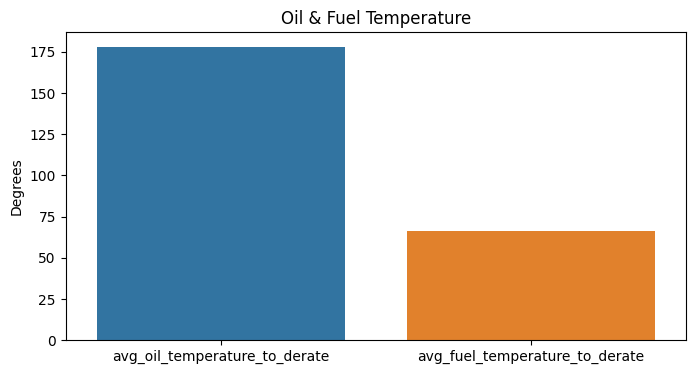

In [76]:
fig, ax = plt.subplots(figsize=(8, 4))
chart = sns.barplot(data = averages3)
chart.set_title('Oil & Fuel Temperature')
chart.set_ylabel('Degrees')
plt.show()

In [77]:
averages2 = averages[["avg_engine_time_to_derate", "avg_fuel_ltd_to_derate"]] 
averages2

,avg_engine_time_to_derate,avg_fuel_ltd_to_derate
0,7635,52531


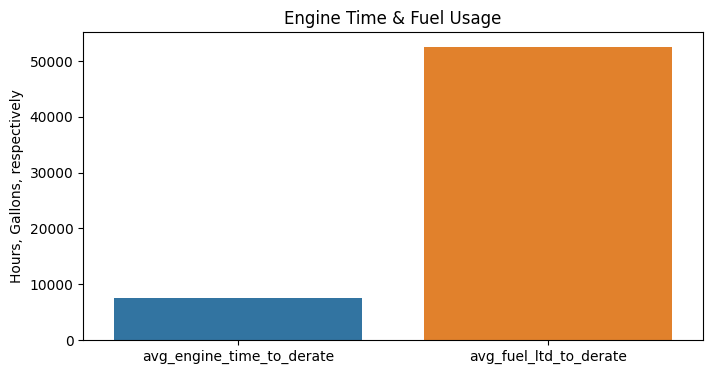

In [79]:
fig, ax = plt.subplots(figsize=(8, 4))
chart = sns.barplot(data = averages2)
chart.set_title('Engine Time & Fuel Usage')
chart.set_ylabel('Hours, Gallons, respectively')
plt.show()

In [80]:
averages1 = averages[["avg_miles_to_derate"]] 
averages1

,avg_miles_to_derate
0,375130


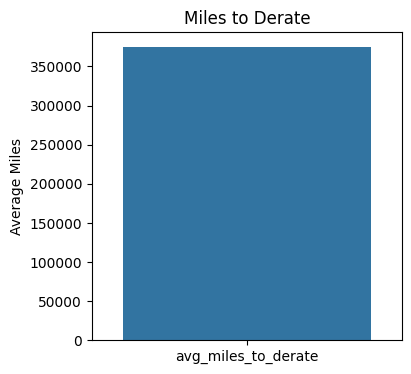

In [84]:
fig, ax = plt.subplots(figsize=(4, 4))
chart = sns.barplot(data = averages1)
chart.set_title('Miles to Derate')
chart.set_ylabel('Average Miles')
plt.show()

In [9]:
import plotly.express as px

#plot_2['spn'] = plot_2['spn'].astype(str)

fig = px.bar(averages, x=['avg mileage to derate', 'avg engine time to derate', 'avg fuel ltd to derate', 'avg oil temperature to derate', 'avg fuel temperature to derate'], y='measure', width=800, height=400, orientation='h',
             color_discrete_sequence=px.colors.qualitative.Antique)
fig.update_layout(showlegend=False)
fig.show()

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['avg mileage to derate', 'avg engine time to derate', 'avg fuel ltd to derate', 'avg oil temperature to derate', 'avg fuel temperature to derate'] but received: measure

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = fault_diag_filtered[fault_diag_filtered['spn'] != 5246]
y = fault_diag_filtered['spn'] == 5246

# Split into training/validation/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scale data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

import tensorflow as tf

# Define RNN architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(None, num_features)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

# Evaluate model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')
